In [3]:
# # Skriptas zive EKG pūpsnių CNN VU klasifikatoriaus testavimui ir tikslumo įvertinimui.
 # Įvertinimas atliekamas su rpeaks, gautais iš Neurokit2, pūpsnių anotacijos paimtos iš 
 # gydytojų koreguoto json failo. Anotacijos paimtos tik tiems rpeaks, kurie randami json faile.
 # Jei yra Neurokit rpeaks, kuriems json faile nerasta atitikmenų, tam rpeaks-ui priskiriama
 # anotacija 'U'.
#  Įvertinimas atitinka realią situaciją, kai gydytojas nesikiša į anotacijų redagavimą.
# Skriptas taip pat gautų anotacijų pūpsnius klasterizuoja ir išveda klasterių grafikus,
# tiek nevidurkintus, tiek vidurkintus. Klasterių skaičius yra užduodamas, priklauso nuo 
# anotacijų skaičiaus - žr.get_clusters_n

# Skriptas pritaikytas tiek Zive, tiek ir MIT2Zive duomenims

# Skripte yra galimybė išvesti ekstrasistolių vietas įraše.
# Dirbant su daug įrašų reiktų užblokuoti: classification = []  # Užblokuota
 
# Pagrindiniai žingsniai:
# - pagrindiniame skripte nurodomi:
    # Naudojamų požymių sąrašas
    # Vietinės talpyklos aplankas ir pūpsnių atributų failas 
    # Nuoroda į modelio aplanką
    # Nurodoma ar filtruoti izolinijos bangavimus
    # Nurodomi klasifikuojamų ir klasterizuojamų failų vardai
    # ciklas per visus nurodytus failus 


import pickle
import pandas as pd
import numpy as np
import neurokit2 as nk
import time
import sys, os, json
from pathlib import Path
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from vertinimas_util import read_signal
from vertinimas_util import AnalyseHeartrate
from vertinimas_util import get_label_sums

from zive_cnn_fda_vu_v3_micro_modif import get_beat_features_set_fda_vu_vasara_v1, get_pred_labels_modif
from zive_cnn_fda_vu_v3_micro_modif import get_normalized_data, predict_cnn_fda_vu_vasara_v2

np.set_printoptions(threshold=sys.maxsize)

def get_sequences_min_max(signal, df_gr, w_side):
# Ieškomi min ir max EKG reikšmės klasterio pūpsniuose
    min_clt = 0
    max_clt = 0
    for index, row in df_gr.iterrows():
        seq_start = row['atr_sample'] - w_side
        if (seq_start < 0):
            continue
        seq_end = row['atr_sample'] + w_side
        if (seq_end >= len(signal)):
            continue
        sequence = signal[seq_start:seq_end] 

        # deltax ir deltay simbolių pozicijų koregavimui
        min = np.amin(sequence)
        if (min < min_clt):
            min_clt = min
        max = np.amax(sequence)
        if (max > max_clt):
            max_clt = max
    return min_clt, max_clt

def show_beats(signal, df_gr, w_side, min, max, fig_width, fig_height, max_graphs=None):
# Atvaizduojami klasterio pūpsniai kiekvienas atskirai
    """
    Parameters
    ------------
        signal: numpy array, float
        df_gr: dataframe after grouping by 'cluster'
        w_side: window width from rpeak, int
        min: float
        max: float
        fig_width: int
        fig_height: int
        max_graphs: max of graphs, int
    """

    seq_nr = 0
    for index, row in df_gr.iterrows():
        # Formuojami grafiniai vaizdai
        seq_start = row['atr_sample'] - w_side
        if (seq_start < 0):
            continue
        seq_end = row['atr_sample'] + w_side
        if (seq_end >= len(signal)):
            continue
        beat_loc = row['atr_sample'] - seq_start
        beat_symbol = row['atr_symbol']
        sequence = signal[seq_start:seq_end] 
        
        dict_attr = {'seq_nr':seq_nr, 'rpeak':row['atr_sample'], 'symbol':beat_symbol}
        print(dict_attr)

        deltay = (max - min)/20
        deltax = len(sequence)/100

        # suformuojame vaizdą
        fig = plt.figure(facecolor=(1, 1, 1), figsize=(fig_width, fig_height))
        ax = plt.gca()
        x = np.arange(0, len(sequence), 1)
        ax.plot(x, sequence, color="#6c3376", linewidth=2)
        ax.set_ylim([min, max+2*deltay])
        ax.annotate(beat_symbol, (beat_loc - deltax,sequence[beat_loc] + deltay))

        seq_nr += 1
        plt.show()
        if (max_graphs != None):
            if (seq_nr >= max_graphs):
                break

def show_beats_in_same_plot(signal, df_gr, w_side,  min, max, fig_width, fig_height):
# Atvaizduojami klasterio pūpsniai klojant vienas ant kito
    """
    Parameters
    ------------
        signal: numpy array, float
        df_gr: dataframe after grouping by 'cluster'
        w_side: window width from rpeak to one side
        min: float
        max: float
        fig_width: int
        fig_height: int
    """
    deltay = (max - min)/20

# Formuojami pūpsnių grafiniai vaizdai ir klojami vienas ant kito
    fig = plt.figure(facecolor=(1, 1, 1), figsize=(fig_width, fig_height))
    ax = plt.gca()
    seq_nr = 0
    for index, row in df_gr.iterrows():
        # Formuojami grafiniai vaizdai
        seq_start = row['atr_sample'] - w_side
        if (seq_start < 0):
            continue
        seq_end = row['atr_sample'] + w_side
        if (seq_end >= len(signal)):
            continue
        # beat_rpeak = row['atr_sample']
        # beat_symbol = row['atr_symbol']
        sequence = signal[seq_start:seq_end] 
        
        # suformuojame vaizdą
        x = np.arange(0, len(sequence), 1)
        ax.plot(x, sequence, color="#6c3376", linewidth=2)
        ax.set_ylim([min, max+2*deltay])
        seq_nr += 1
    plt.show()

def show_beats_in_group(signal, df_attr_ml_group_X, group_symbol, w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks):
        
        # Sugrupuojame atributus pagal klasterius,
        # surandame klasterių indeksus mažėjančia klasterių dydžio tvarka 
    gr = df_attr_ml_group_X.groupby(['cluster'])
    sr_sizes = gr.size()
    sr_sizes = sr_sizes.sort_values(ascending=False)
    df_sizes = sr_sizes.to_frame(name='sizes').reset_index()

    # čia įdedame spausdinimo ciklą per klasterius, išvesdami klasterių statistiką
    print("\nML anotacija", group_symbol, ":" )
    for item, row in df_sizes.iterrows():
        cluster = row['cluster']
        df_gr = gr.get_group(cluster)
        atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
        (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
        total = counts.sum()
        print(f'item: {item:>6}   cluster: {cluster:>6}   statistika: {unique} {counts} {total}')

        # Jei print_rpeaks == True, tai S, V ir U atvejais išvedame anotacijų rpeaks
        if (print_rpeaks and ((group_symbol == "S" or group_symbol == "V" or group_symbol == "U"))):
            # print(df_gr.head(6))
            dict_X = dict(zip(df_gr['idx'], df_gr['atr_sample']))
            print(group_symbol,': (idx, rpeak)', dict_X)

    # Ciklas per užduotus klasterius
    clusters_sorted = sr_sizes.index
    n_clusters = gr.ngroups

    # Ciklas per klasterius
    for item in range(n_clusters):
        cluster = clusters_sorted[item]
        df_gr = gr.get_group(cluster)
        print('\nitem:', item, 'cluster:', cluster, 'size:', len(df_gr))

        #  Statistika apie pūpsnius klasteryje
        atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
        (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
        total = counts.sum()
        print("statistika klasteryje: ", unique, counts, total)

        if (len(df_gr) == 1):
            dict_attr = {'seq_nr':0, 'rpeak':df_gr['atr_sample'].values[0], 'symbol':df_gr['atr_symbol'].values[0]}
            print(dict_attr)        

        # Grafika
        # mark1
        min, max = get_sequences_min_max(signal, df_gr, w_side)
        show_beats_in_same_plot(signal, df_gr, w_side, min, max, fig_width, fig_height)
# mark2
        show_N_beats_in_same_plot(signal, df_gr, w_side, min, max, fig_width, fig_height)
        
        if ((max_graphs != 0) and (len(df_gr) != 1)):
            show_beats(signal, df_gr, w_side, min, max, fig_width, fig_height, max_graphs= max_graphs)

    return

def show_N_beats_in_same_plot(signal, df_gr, w_side,  min, max, fig_width, fig_height):
# Atvaizduojami klasterio pūpsniai klojant vienas ant kito
    """
    Parameters
    ------------
        signal: numpy array, float
        df_gr: dataframe after grouping by 'cluster'
        w_side: window width from rpeak to one side
        min: float
        max: float
        fig_width: int
        fig_height: int
    """
    deltay = (max - min)/20

    # print(df_gr.head())

    #  Suvidurkiname sekas
    seq_nr = 0
    avg_sequence = np.zeros((w_side*2))
    for index, row in df_gr.iterrows():
        # Formuojami grafiniai vaizdai
        seq_start = row['atr_sample'] - w_side
        if (seq_start < 0):
            continue
        seq_end = row['atr_sample'] + w_side
        if (seq_end >= len(signal)):
            continue
        # beat_rpeak = row['atr_sample']
        # beat_symbol = row['atr_symbol']
        sequence = signal[seq_start:seq_end]
        avg_sequence = np.add(avg_sequence, sequence)
        seq_nr += 1
    avg_sequence = avg_sequence/seq_nr    


# Formuojamas grafinis vaizdas
    fig = plt.figure(facecolor=(1, 1, 1), figsize=(fig_width, fig_height))
    ax = plt.gca()
    # suformuojame vaizdą
    x = np.arange(0, len(avg_sequence), 1)
    ax.plot(x, sequence, color="#6c3376", linewidth=2)
    ax.set_ylim([min, max+2*deltay])
    plt.show()


def zive_read_rec_id(db_path, file_name):
    file_path = Path(db_path, file_name + '.json')
    with open(file_path,'r', encoding="utf8") as f:
        data = json.loads(f.read())
    userId = data["userId"]
    recId = data["recordingId"]
    return userId, recId

def clustering(df_attr_features_ml_group_X, features, scaler, n_clusters):
    
    if (n_clusters > 1):
        # Paliekame tik užduotus požymius ir normalizuojame
        df_tmp = df_attr_features_ml_group_X[features]
        # print(data_frame_init.head())
        # Duomenis normalizuojame
        X = scaler.transform(df_tmp)

        # define the model
        model = KMeans(n_clusters, random_state=0)

        # fit the model
        model.fit(X)

        # assign a cluster to each example
        yhat = model.predict(X)
        # print(type(yhat), yhat.shape)

        # retrieve unique clusters
        clusters = np.unique(yhat)
        # print(clusters)
    else:
        yhat = np.zeros(len(df_attr_features_ml_group_X), int)

    # Paliekame masyvus tik su atributais, be požymių, požymių stulpelius panaikiname
    df_attr_ml_group_X = df_attr_features_ml_group_X.drop(features, axis=1, inplace=False)

    # Papildome atributus klasterių numeriais 
    df_attr_ml_group_X['cluster'] = list(yhat)
    # print("\nKlasteris be U: df_attr_be_U")
    return df_attr_ml_group_X


def get_clusters_n(len_group):
    """
    Nustato, į kiek klasterių dalinti pūpsnių grupę, priklausomai 
    nuo grupės dydžio len_group
    len_group: int, grupės dydis
    """
    clusters_n = 0
    if (len_group >= 500):
        clusters_n = 10
    elif len_group >= 100 and len_group <500:
        clusters_n = 5
    elif len_group >= 10 and len_group <100:
        clusters_n = 3
    return clusters_n


def get_rpeaks_of_clusters_modif(df_attr_ml_group_N):
    
    list_dict_clusters = []
    group_by_cluster = df_attr_ml_group_N.groupby(['cluster'])
    
    sr_sizes = group_by_cluster.size()
    sr_sizes = sr_sizes.sort_values(ascending=False)
    # print('sr_sizes:', sr_sizes)

 # Ciklas per užduotus klasterius
    clusters_sorted = sr_sizes.index
    n_clusters = group_by_cluster.ngroups

    # Ciklas per klasterius
    for item in range(n_clusters):
        cluster_number = clusters_sorted[item]
        df_gr = group_by_cluster.get_group(cluster_number)
        # print('\nitem:', item, 'cluster:', cluster_number, 'size:', len(df_gr))
        lst_rpeaks = df_gr["atr_sample"].values.tolist()
        # print(lst_rpeaks)
        dict_cluster = {
                # "annotationValue": annotationValue,
                "clusterNumber": item,
                "rpeakLocations": lst_rpeaks
            }
        list_dict_clusters.append(dict_cluster)

    return list_dict_clusters       


def get_clusters(df_attr_features_be_U, omitted_lst, predictions, atr_sample, idx_lst, all_features, scaler, signal ):

    # print('predictions:', len(predictions))
    # print('omitted_lst:', len(omitted_lst))
    # print('atr_sample:', len(atr_sample))

    all_beats =  {'N':0, 'S':1, 'V':2, 'U':3}

    # Maksimalus grafikų skaičius, išvedant kiekvieną grafiką klasteryje atskirai 
    max_graphs = 0

    # EKG pūpsnio reikšmių lango į vieną pusę plotis
    w_side = 80*5

    # Lango, kuriame vaizduojami grafikai, plotis ir aukštis
    fig_width, fig_height = 20, 6

    # Užduodame, ar rodyti klasterį su U
    U_flag = True  #  True - rodyti

    # Užduodame, ar išvesti S, V, U anotacijoms rpeaks
    print_rpeaks = False  # True - rodyti

    # //////////////// PARUOŠIAME DUOMENŲ MASYVUS KLASTERIZACIJAI  //////////////////////////////////

    # Parengiame R pikų ir ML anotacijų masyvus taip, kad juose nebūtų elementų iš omitted_lst,
    # taip pat atmetame reikšmes su indeksu 1 ir len(atr_sample)-1)

    # Atmetame reikšmes su indeksu 1 ir len(atr_sample)-1), nes buvo skaičiuojami požymiai be jų
    atr_sample = atr_sample[idx_lst]

    # Suformuojame atr_sample_su_U ir be_U
    if (omitted_lst):
        # print('omitted_lst:', omitted_lst)
        atr_sample_be_U = np.asarray([atr_sample[item] for item in range(len(atr_sample)) if (item not in omitted_lst)])
        # print("atmetus su 'U':", len(atr_sample_be_U))
        # print("atr_sample_be_U:", atr_sample_be_U[:50])
    else:
        atr_sample_be_U = atr_sample

    # Suformuojame atr_symbol_be_U panaudodami atpažintus atr_labels_be_U
    atr_labels_be_U = predictions
    invers_all_beats = {v: k for k, v in all_beats.items()}
    atr_symbol_be_U = np.array([invers_all_beats[sample] for sample in atr_labels_be_U])
    # print("atr_symbol_be_U:",atr_symbol_be_U[:50])

    # Pūpsnių statistika
    # (unique, counts) = np.unique(atr_symbol_be_U, return_counts=True)
    # total = counts.sum()
    # print("class labels: ", unique, counts, total)

    # Pridedame atributus atr_sample_be_U, atr_symbol_be_U prie požymių datafreimo,
    # skirto klasterizacijai
    df_attr_features_be_U['atr_sample'] = atr_sample_be_U
    df_attr_features_be_U['atr_symbol'] = atr_symbol_be_U
    # print('df_attr_features_be_U.head():')
    # print(df_attr_features_be_U.head())
    print("\nMasyvas be U: df_attr_features_be_U len:", len(df_attr_features_be_U) )
    # print(df_attr_features_be_U.columns)

    # Šitoj vietoj turime:
    # atr_sample_be_U
    # atr_labels_be_U
    # atr_symbol_be_U
    # df_attr_features_be_U


    # # Suformuojame masyvą su `U` df_attr_su_U, kuris bus naudojamas kaip atskiras klasteris
    # # df_attr_su_U = pd.DataFrame(columns=['atr_sample', 'atr_symbol',  'cluster'])
    df_attr_su_U = pd.DataFrame()
    if (omitted_lst):
        attr_su_U = []
        for item in omitted_lst:
            dict_tmp = {
                'idx': item,
                'atr_sample': atr_sample[item],
                'atr_symbol': 'U',
                'cluster': 0
            }
            attr_su_U.append(dict_tmp)
        df_attr_su_U = pd.DataFrame(attr_su_U)
        # print(df_attr_su_U.head())
    print("Masyvas su U: df_attr_su_U len:", len(df_attr_su_U) )
    

# /////////////////  ML anotacijų N, S, V grupių klasterizacija. Anotacijos U neklasterizuojamos

    # Sugrupuojame atributus pagal ML grupes
    ml_groups = df_attr_features_be_U.groupby(['atr_symbol'])

    # Klasterizuojame ML grupes  N, S, V kiekvieną atskirai
    # N grupės klasterizacija
    print("\nInformacija apie klasterius:")
    list_dict_clusters_full = []

    if 'N' in ml_groups.groups.keys():
        df_attr_features_ml_group_N = ml_groups.get_group('N')
        n_clusters_N = get_clusters_n(len(df_attr_features_ml_group_N))
        df_attr_ml_group_N = clustering(df_attr_features_ml_group_N, all_features, scaler, n_clusters_N)
        print("\nKlasteriai su 'N' anotacija:")
        list_dict_clusters = get_rpeaks_of_clusters_modif(df_attr_ml_group_N)
        # print(list_dict_clusters)
        list_dict_clusters_full.append({'atr_symbol': 'N', "clusters":list_dict_clusters})
    
        show_beats_in_group(signal, df_attr_ml_group_N, 'N', w_side, min, max, fig_width, fig_height, max_graphs, False)

    # S grupės klasterizacija
    if 'S' in ml_groups.groups.keys():
        df_attr_features_ml_group_S = ml_groups.get_group('S')
        n_clusters_S = get_clusters_n(len(df_attr_features_ml_group_S))
        df_attr_ml_group_S = clustering(df_attr_features_ml_group_S, all_features, scaler, n_clusters_S)
        print("\nKlasteriai su 'S' anotacija:")
        list_dict_clusters = get_rpeaks_of_clusters_modif(df_attr_ml_group_S)
        # print(list_dict_clusters)
        list_dict_clusters_full.append({'atr_symbol': 'S', "clusters":list_dict_clusters})

        show_beats_in_group(signal, df_attr_ml_group_S, 'S', w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks)


    # V grupės klasterizacija
    if 'V' in ml_groups.groups.keys():
        df_attr_features_ml_group_V = ml_groups.get_group('V')
        n_clusters_V = get_clusters_n(len(df_attr_features_ml_group_V))
        df_attr_ml_group_V = clustering(df_attr_features_ml_group_V, all_features, scaler, n_clusters_V)
        
        # list_dict_clusters = get_rpeaks_of_clusters_modif(df_attr_ml_group_V)
        print("\nKlasteriai su 'V' anotacija:")
        list_dict_clusters = get_rpeaks_of_clusters_modif(df_attr_ml_group_V)
        # print(list_dict_clusters)
        list_dict_clusters_full.append({'atr_symbol': 'V', "clusters":list_dict_clusters})
        
        # show_beats_in_group(signal, df_attr_ml_group_V, 'V', w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks)

    if (omitted_lst):
        print("\nKlasteris su 'U' anotacija:")
        list_dict_clusters = get_rpeaks_of_clusters_modif(df_attr_su_U)
        # print(list_dict_clusters)
        list_dict_clusters_full.append({'atr_symbol': 'U', "clusters":list_dict_clusters})
        # show_beats_in_group(signal, df_attr_su_U, 'U', w_side, min, max, fig_width, fig_height, max_graphs, print_rpeaks)    

    # print("\nvisi klaster rpeaks")
    # print(list_dict_clusters_full)

    # Serializuojame ir įrašome į failą
    json_object = json.dumps(list_dict_clusters_full)

    return json_object


def classify_clusterise_cnn_fda_vu_v1(signal, atr_sample, model_dir, all_features):
# Tai vedantysis skriptas, į kurį kreipiasi analyse.py

    idx_lst = list(range(1, len(atr_sample)-1))
    # print("len(atr_sample):",  len(atr_sample), "len(idx_lst):",  len(idx_lst))

    # Formuojame iš pūpsnių požymių masyvą
    data_frame, omitted_lst = get_beat_features_set_fda_vu_vasara_v1(signal, atr_sample, idx_lst)

    # Surandame pūpsnių indeksus, kuriems požymiai apaskaičiuoti, ir kuriems - ne 
    data_frame_index = data_frame.index
    # print("len(data_frame.index):", len(data_frame_index))
    # print(omitted_lst)
    
    # Normalizuojame masyvą su apskaičiuotais požymiais
    data_array = get_normalized_data(data_frame, model_dir, all_features)

    # Atpažistame pūpsnių ML klases
    predictions = predict_cnn_fda_vu_vasara_v2(data_array, model_dir)
    # predictions gauti tik indeksams, kurie nėra sąraše omitted_lst

    # Suformuojame pūpsnių ML anotacijas
    pred_y = get_pred_labels_modif(predictions, data_frame_index, omitted_lst, atr_sample)
    # pred_y gautas atr_sample, aprėžtam su idx_lst, įeina taip pat indeksai, nurodyti faile omitted_lst

    (unique,counts) = np.unique(pred_y, return_counts=True)
    total = counts.sum()
    print("pred_y:", unique, counts, total) 
   
    
    # print('len(atr_sample):', len(atr_sample), 'len(idx_lst):', len(idx_lst)) 
    # print('len(predictions):', len(predictions))
    
    # dlist = []
    # for i in range(len(classification)):
    #     dict =  classification[i]
    #     if (dict['annotation'] != 'N'):
    #         dlist.append({i: classification[i]})
    # print()        
    # print(dlist)

    # pridedame dar vieną funkciją - klasterizacijai:
     # Nuskaitome scaler objectą
    path_scaler = Path(model_dir, 'scaler.pkl')  
    scaler = pickle.load(open(path_scaler,'rb'))
    json_object = get_clusters(data_frame, omitted_lst, predictions, atr_sample, idx_lst, all_features, scaler, signal )
    
    return pred_y, json_object


Skriptas zive-arrh EKG segmentų klasterizacijai
Modelis CNN VU su EKG sekos reikšmėmis, EKG formos požymiais, RR intervalais prieš ir po R dantelio
OS in my system :  linux

Bendras duomenų aplankas:  /home/kesju/DI
Zive duomenų aplankas:  DUOM_2022_RUDUO_2
Aplankas su originaliais EKG įrašais ir anotacijomis (.json)  /home/kesju/DI/DUOM_2022_RUDUO_2/records_selected
Diskretizavimo dažnis:  200
Klasifikavimo schema: {'N': 0, 'S': 1, 'V': 2}
Klasių skaičius: 3
Visos galimos anotacijos: ['N', 'S', 'V', 'U']
Modelio ir scaler parametrai nuskaitomas iš aplanko:  /home/kesju/DI/MODELIAI/model_cnn_fda_vu_v1

EKG įrašas nefiltruotas

Atliekama pūpsnių su anotacijomis ['N', 'S', 'V'] pacientų įrašuose klasifikacija ir klasterizacija
Įrašų sąrašas: ['10001.001']

Zive įrašas:  10001.001
file_name: 10001.001 userId: 100 recId: 10001 signal_length: 120370  rpeaks: 761
pred_y: [0 1 3] [753   6   2] 761

Masyvas be U: df_attr_features_be_U len: 759
Masyvas su U: df_attr_su_U len: 0

Informacija api

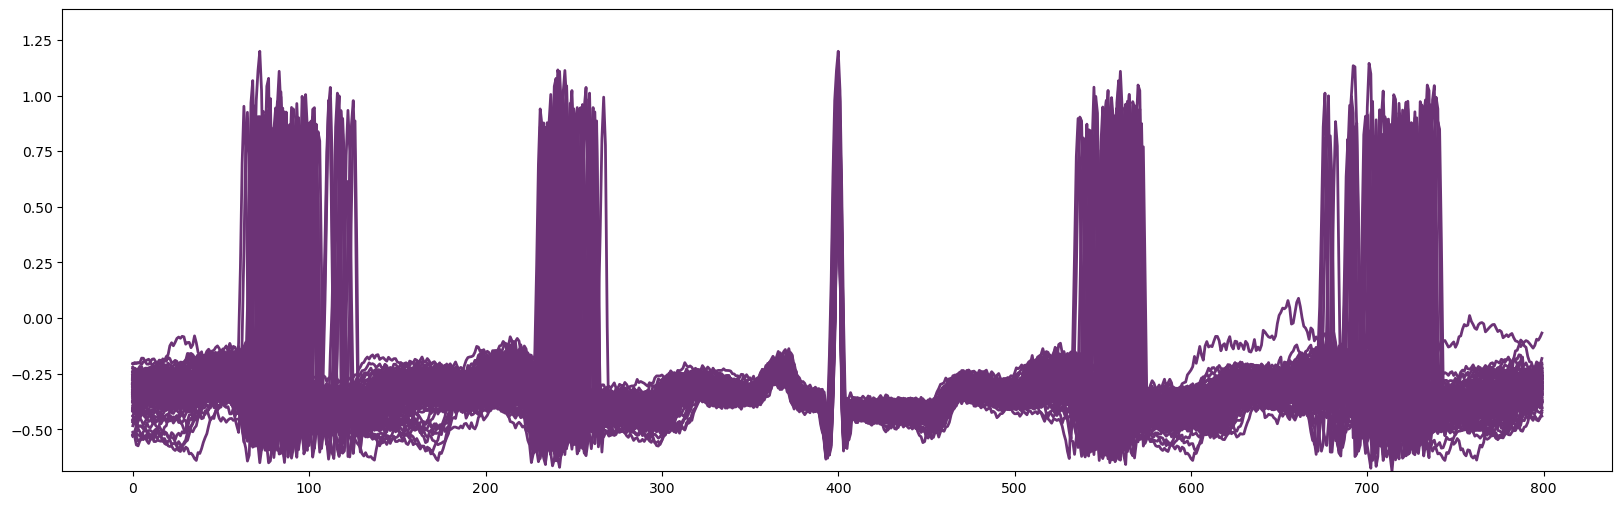

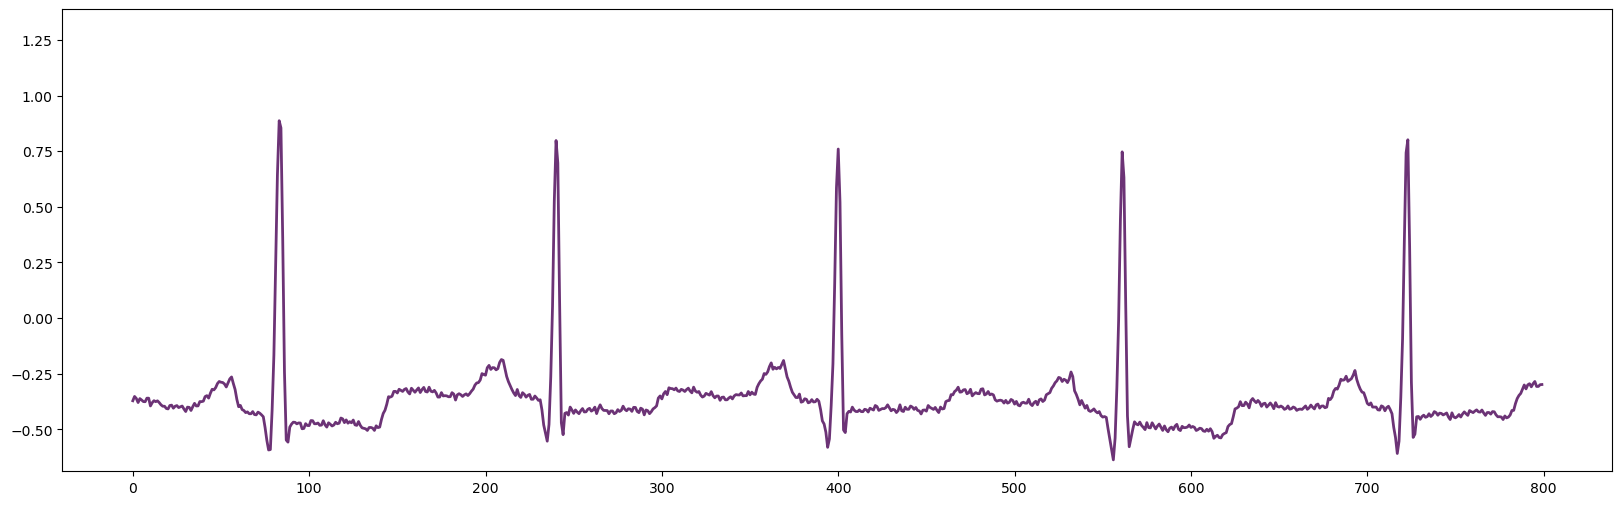


item: 1 cluster: 1 size: 113
statistika klasteryje:  ['N'] [113] 113


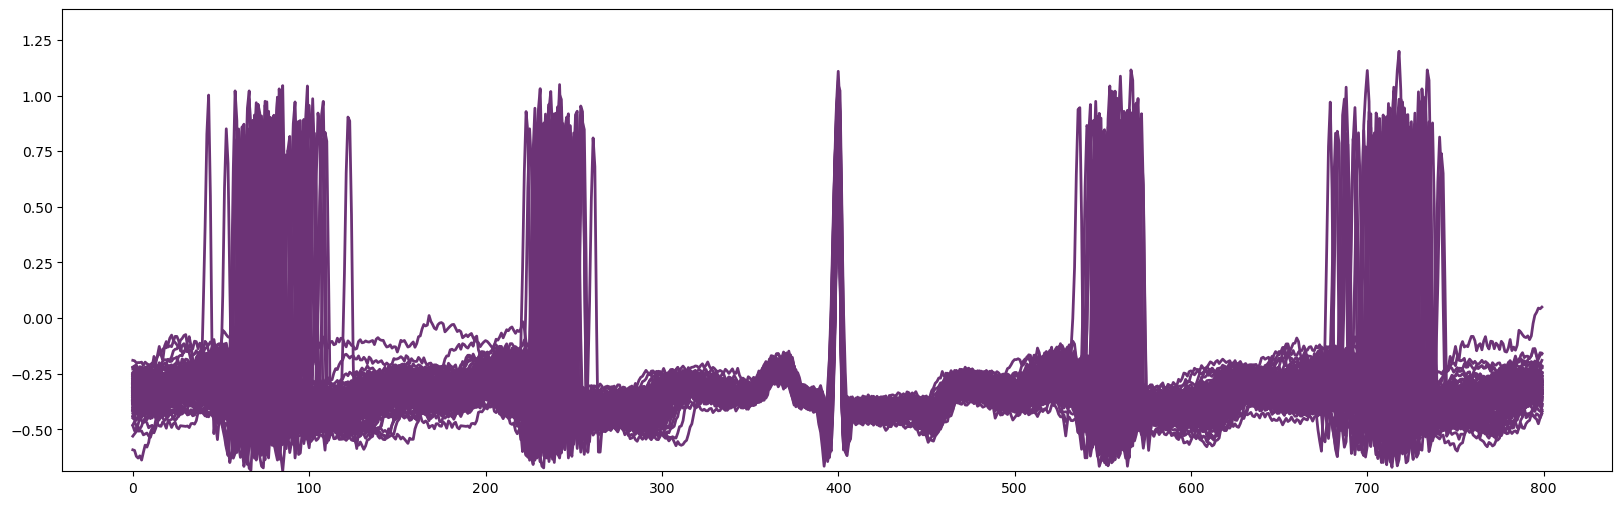

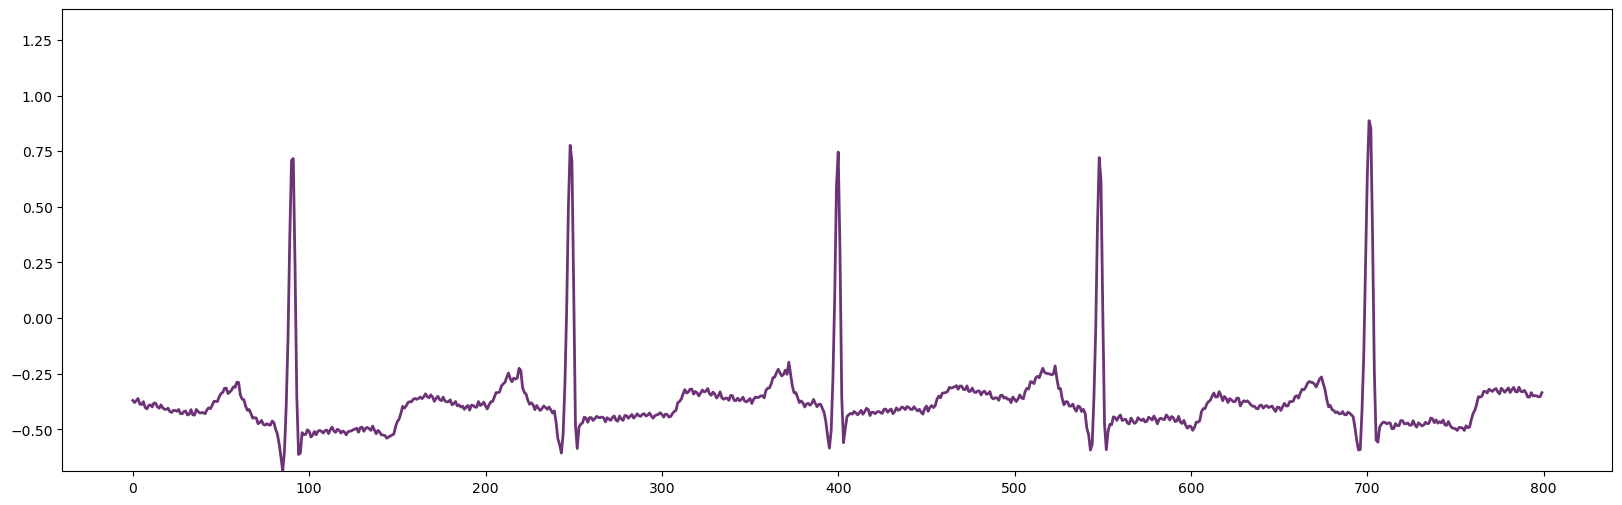


item: 2 cluster: 8 size: 113
statistika klasteryje:  ['N'] [113] 113


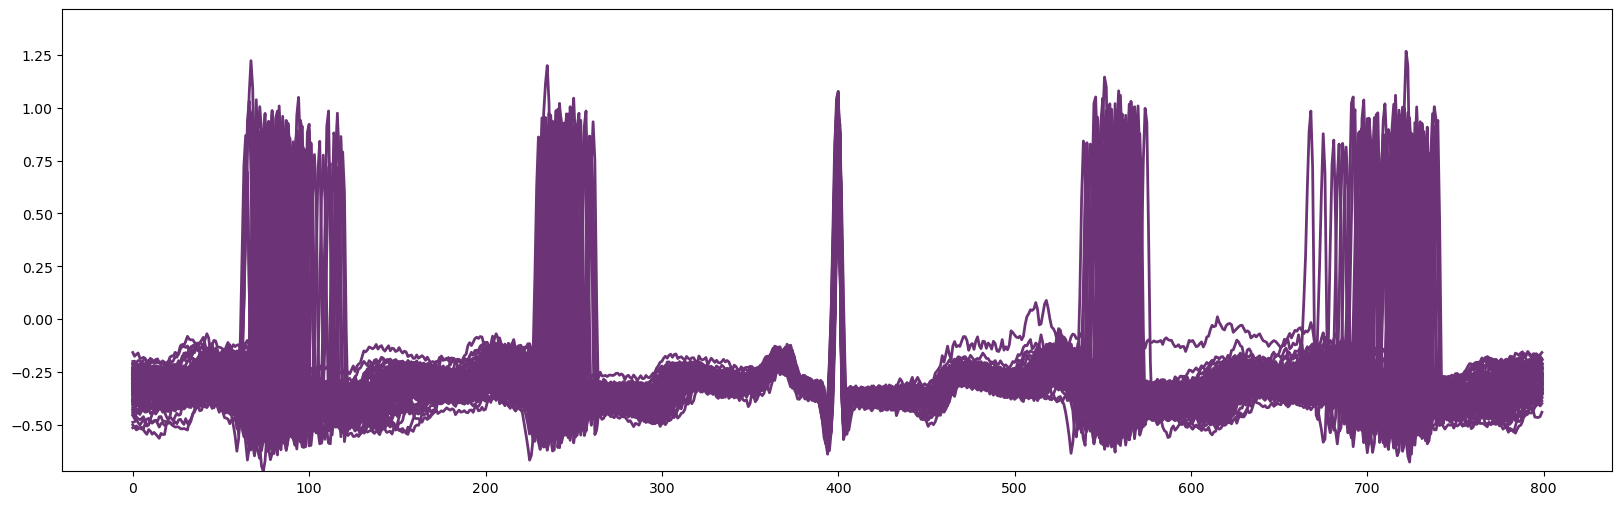

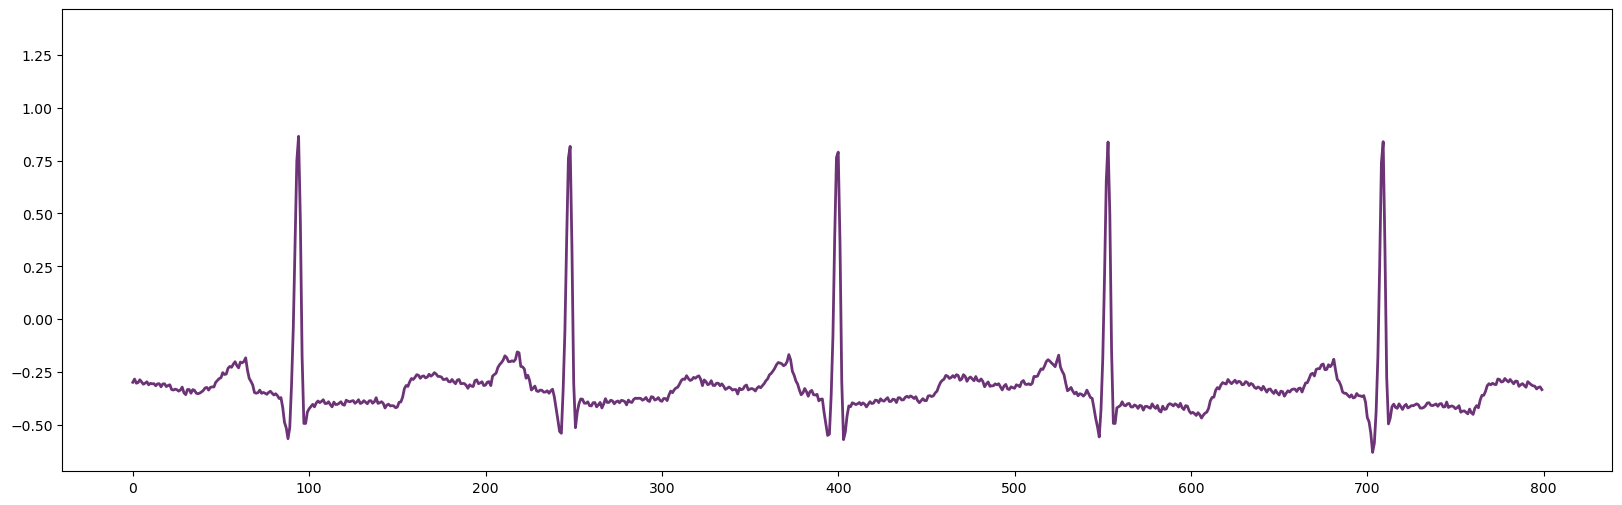


item: 3 cluster: 9 size: 112
statistika klasteryje:  ['N'] [112] 112


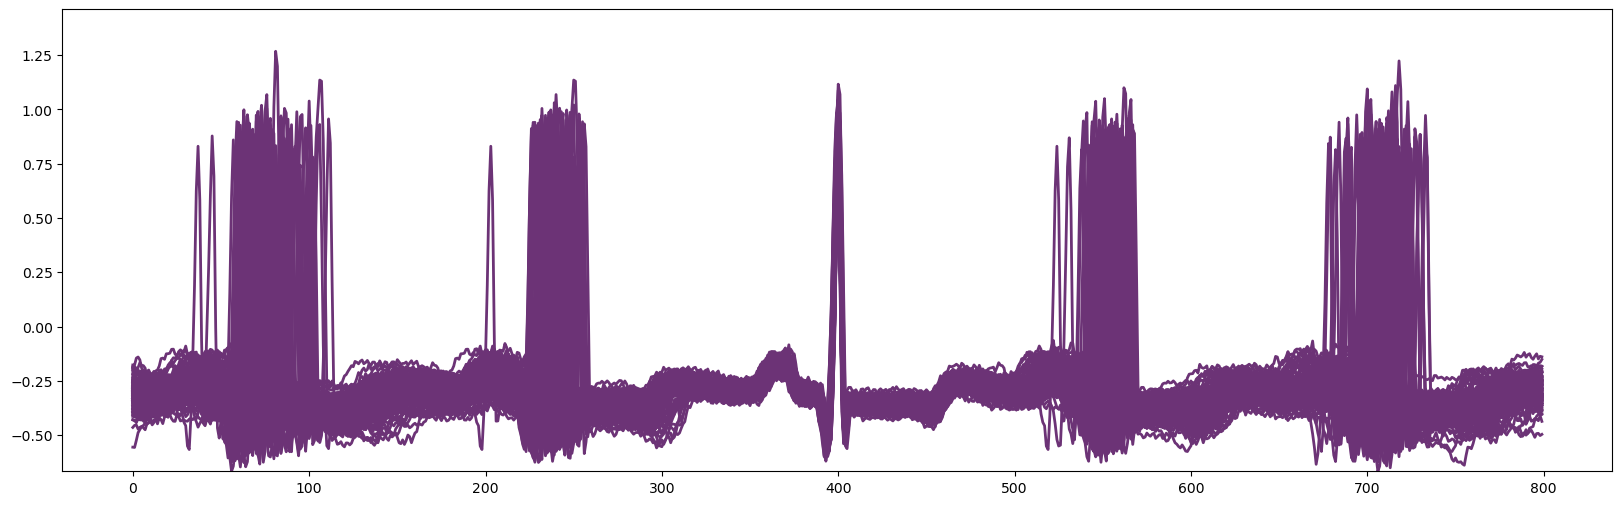

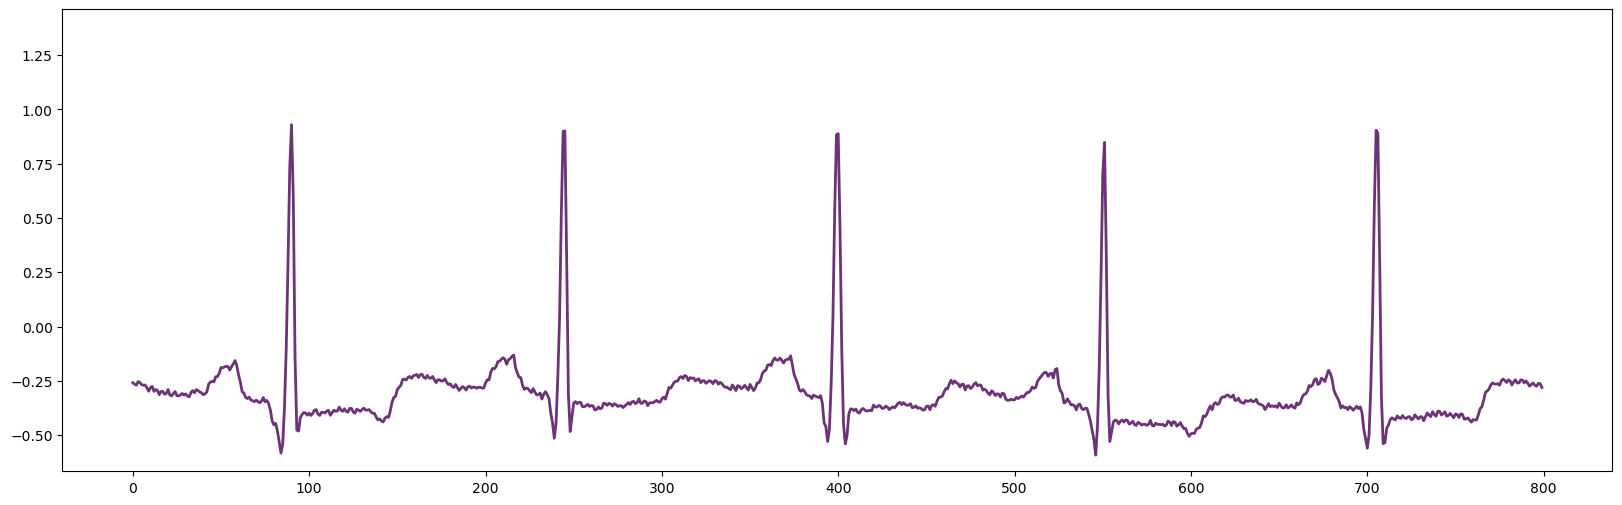


item: 4 cluster: 3 size: 83
statistika klasteryje:  ['N'] [83] 83


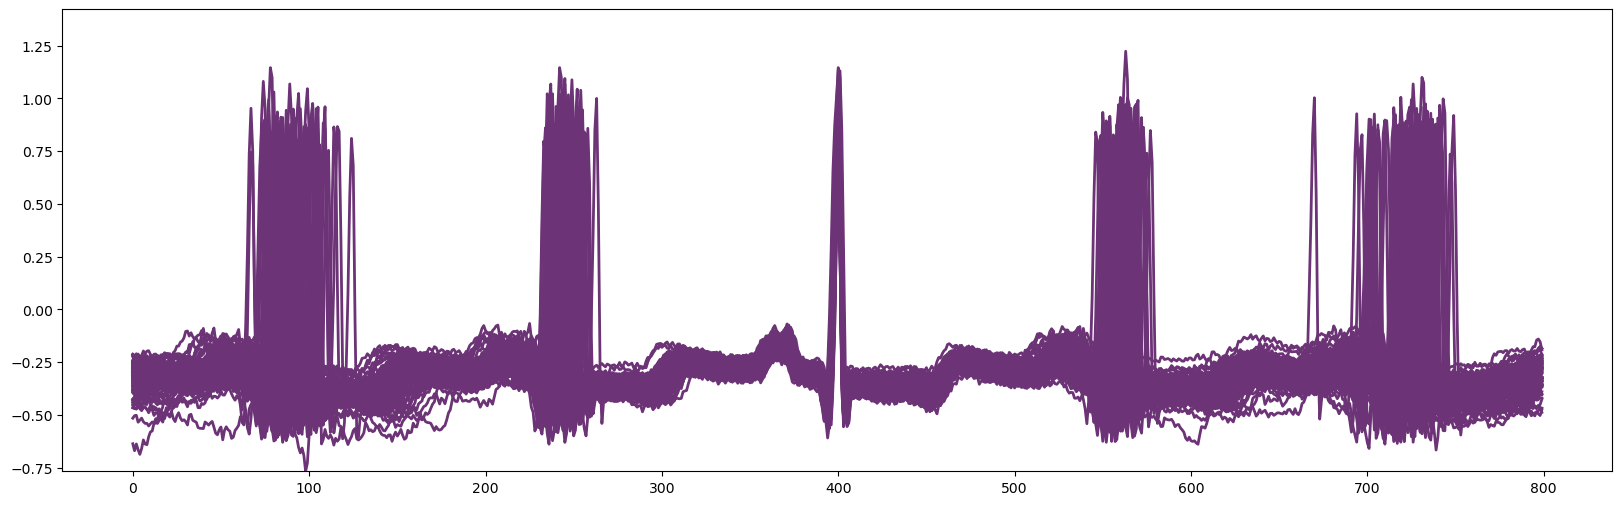

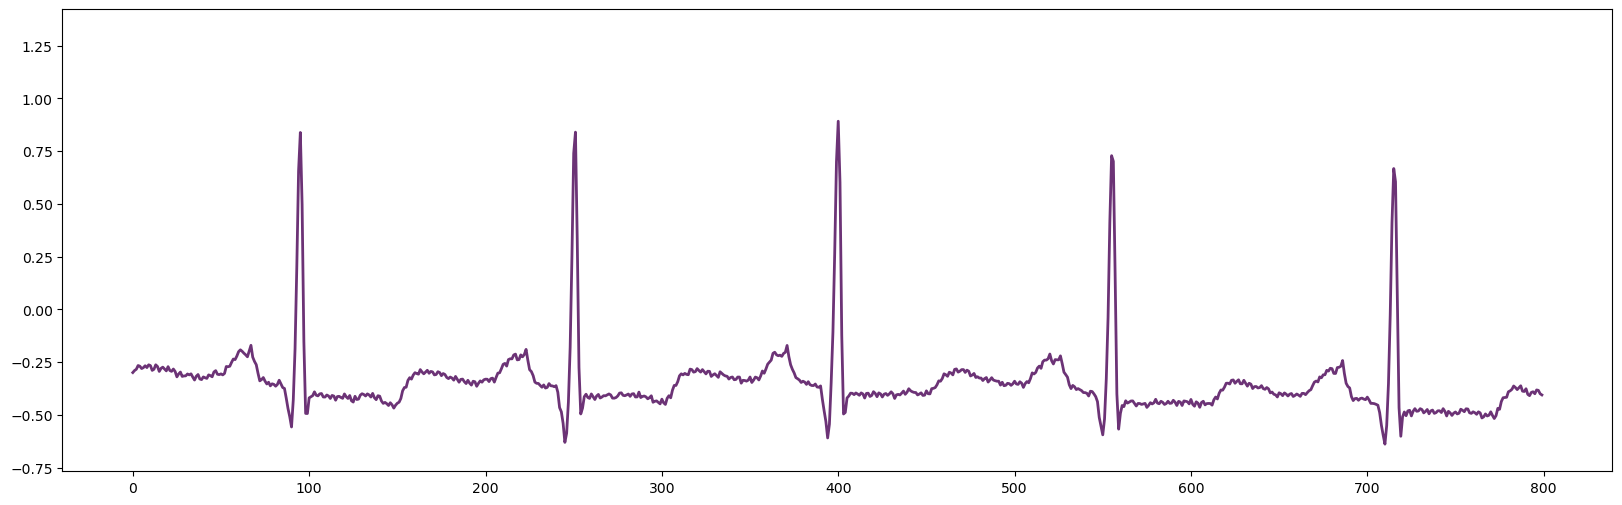


item: 5 cluster: 6 size: 62
statistika klasteryje:  ['N'] [62] 62


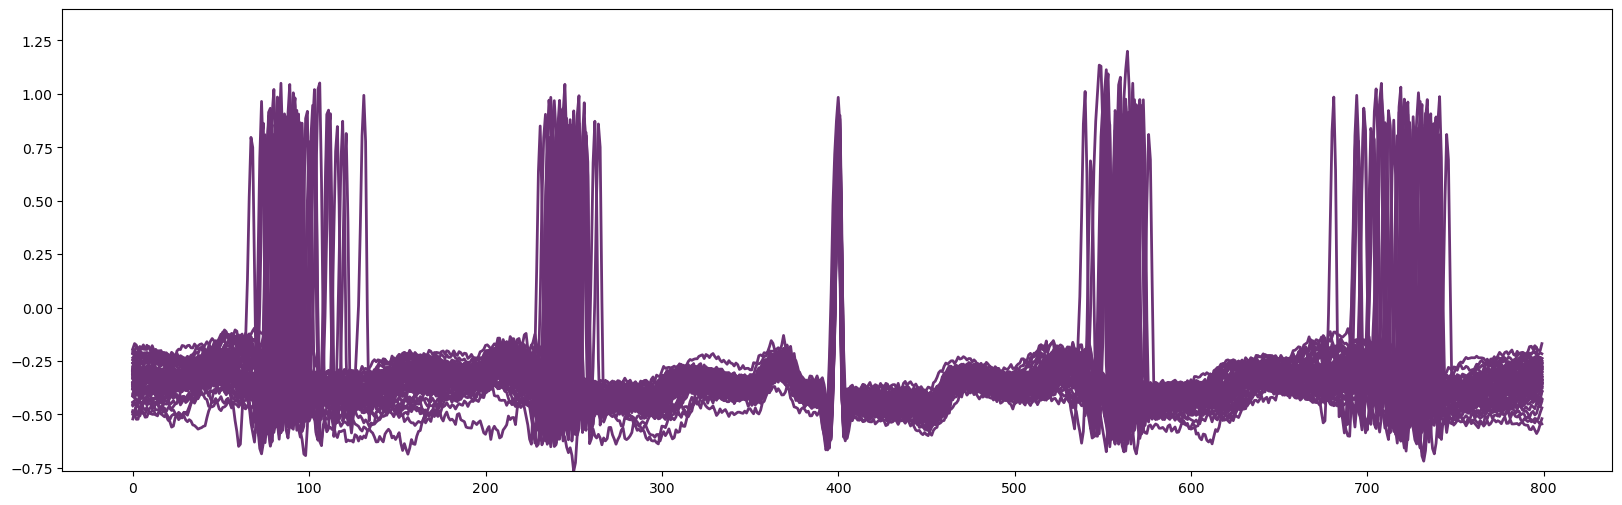

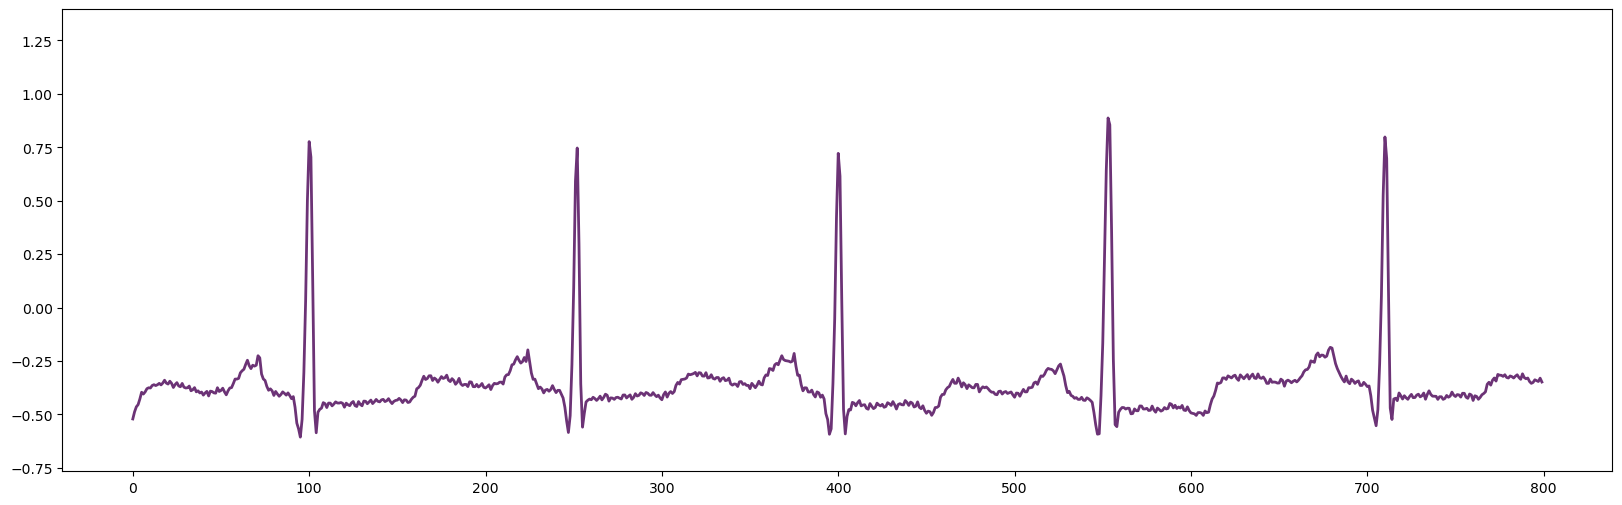


item: 6 cluster: 7 size: 59
statistika klasteryje:  ['N'] [59] 59


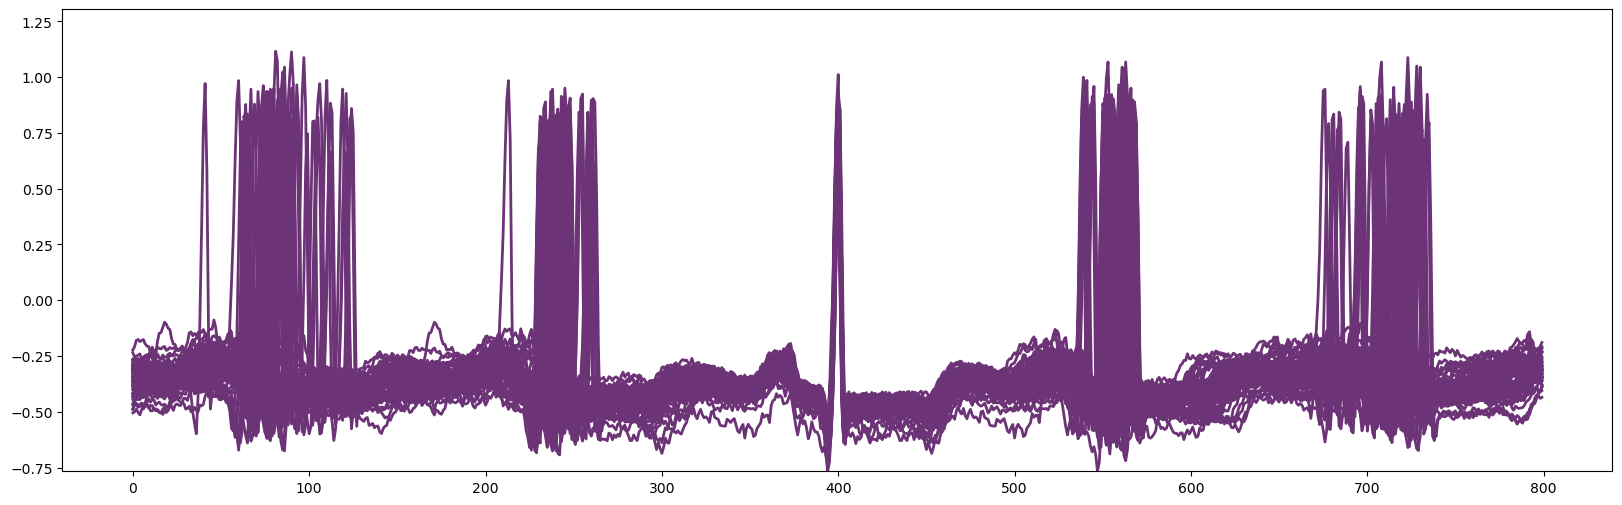

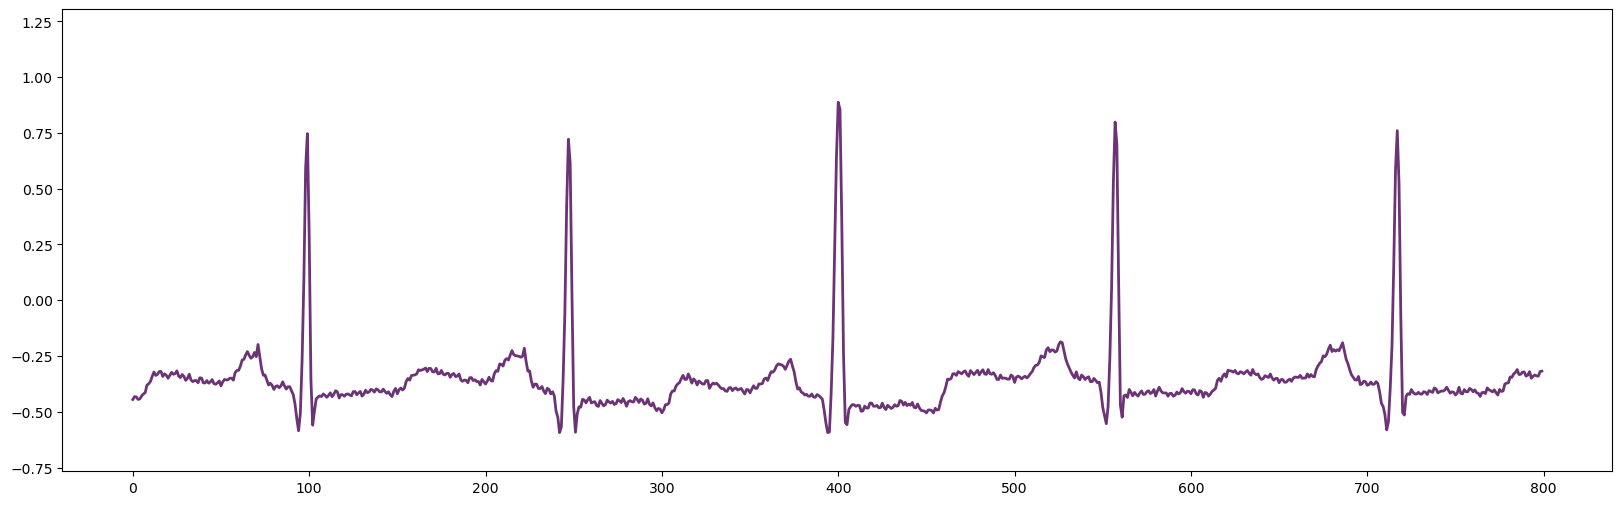


item: 7 cluster: 4 size: 48
statistika klasteryje:  ['N'] [48] 48


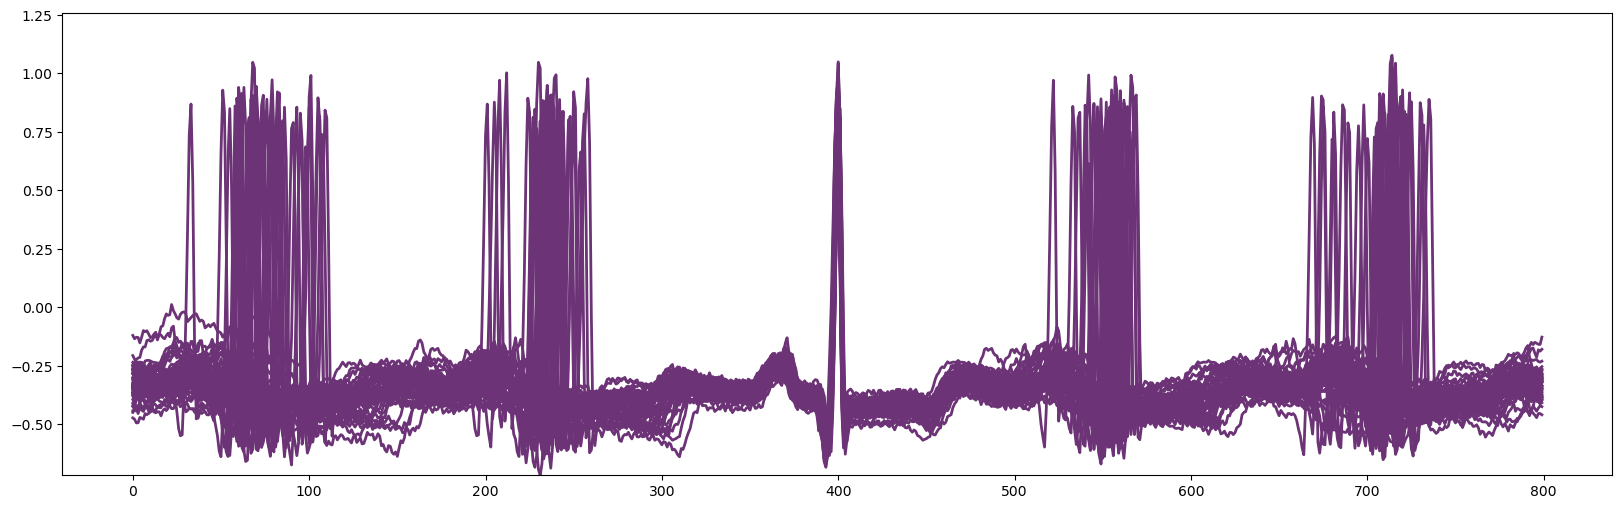

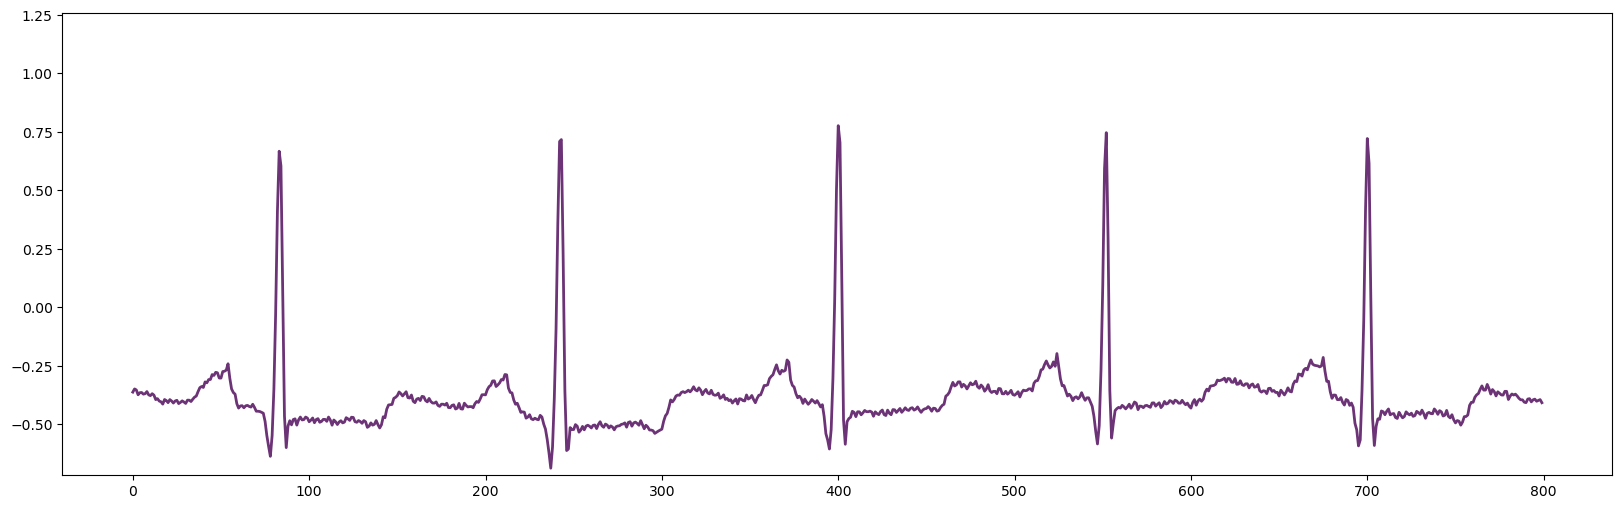


item: 8 cluster: 5 size: 46
statistika klasteryje:  ['N'] [46] 46


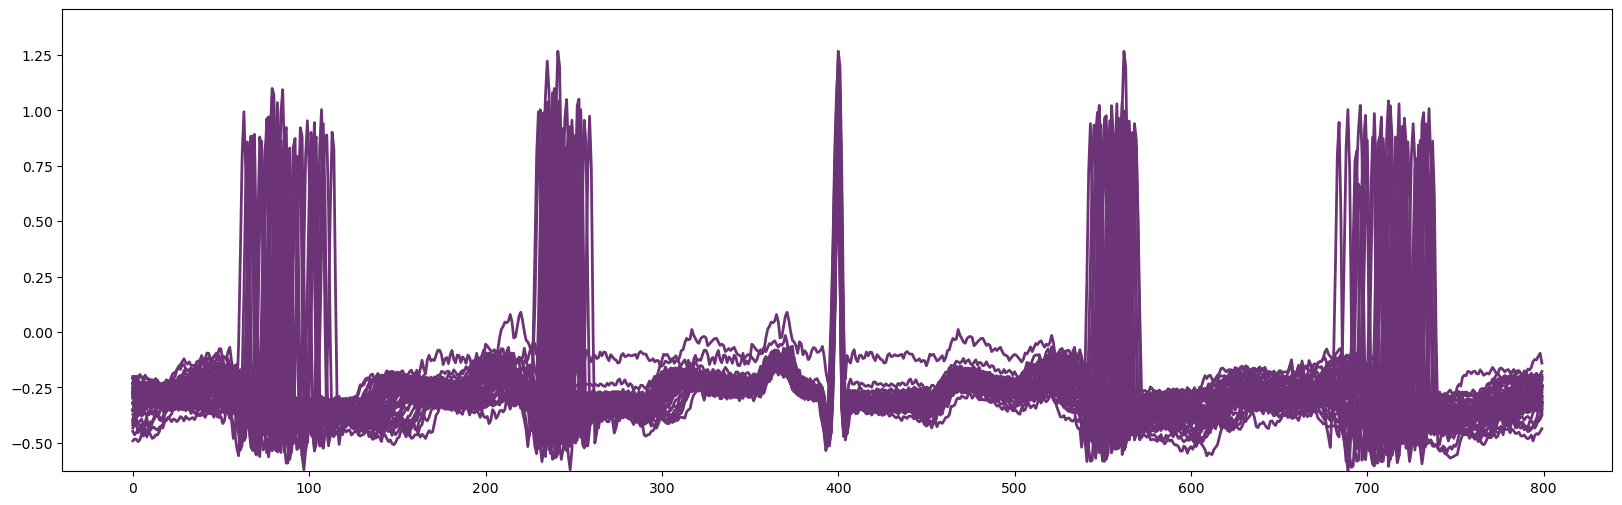

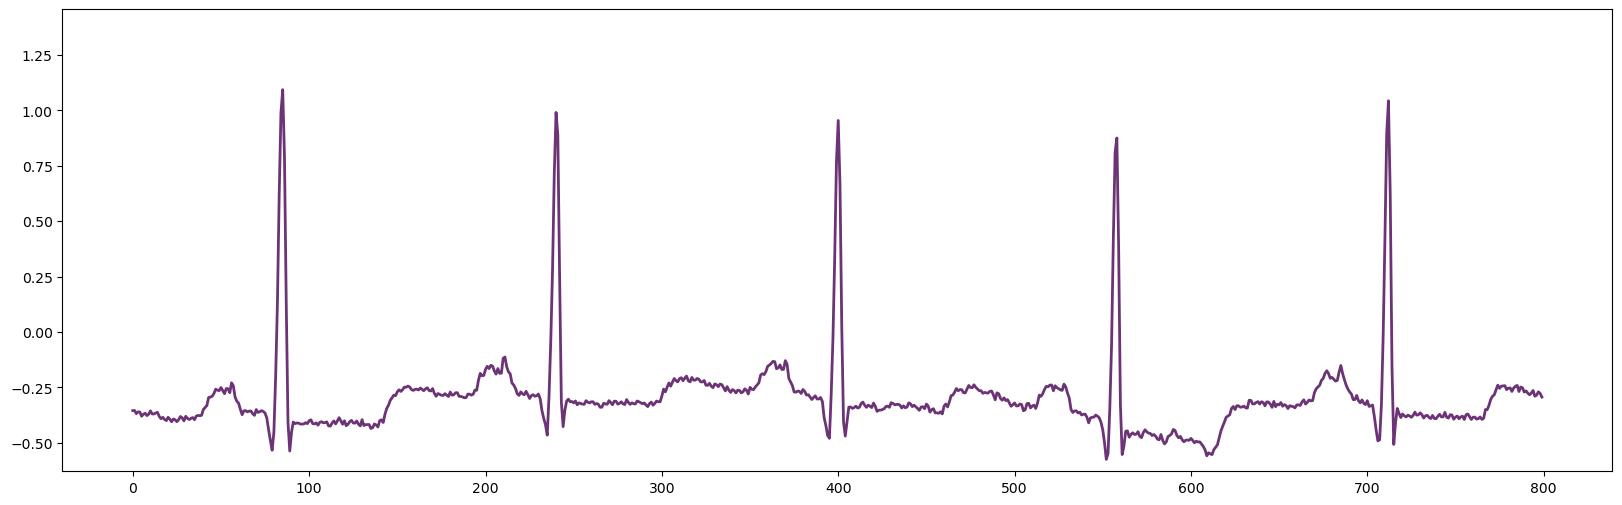


item: 9 cluster: 0 size: 3
statistika klasteryje:  ['N'] [3] 3


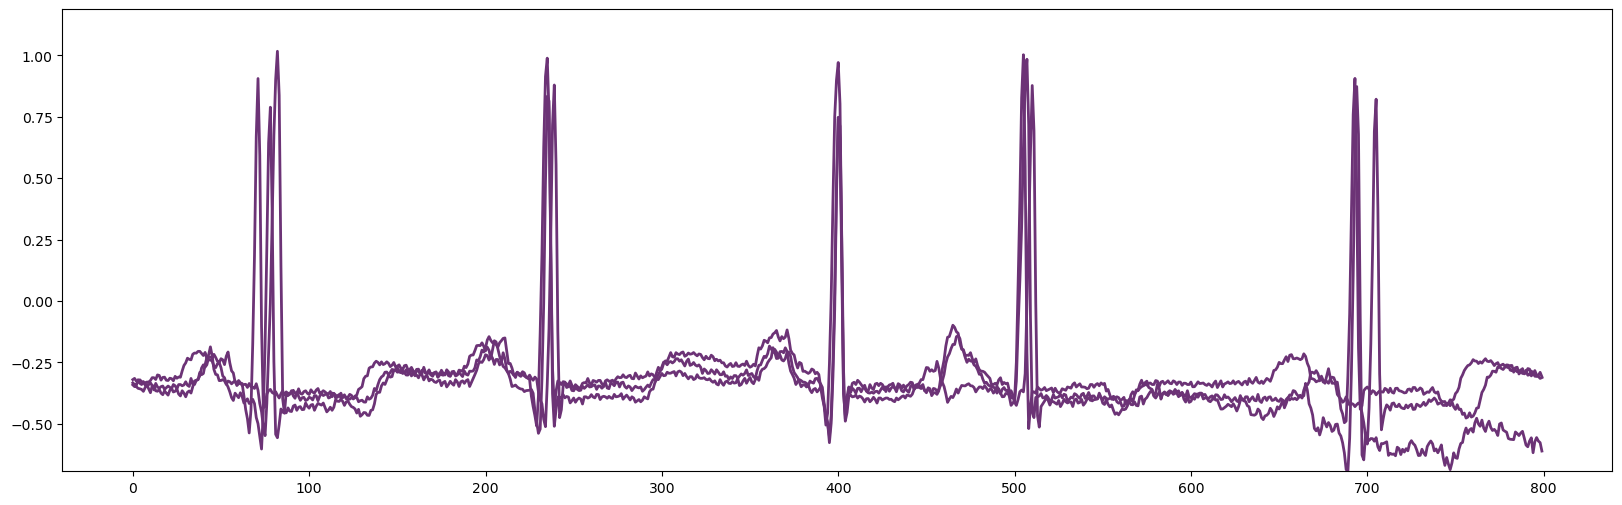

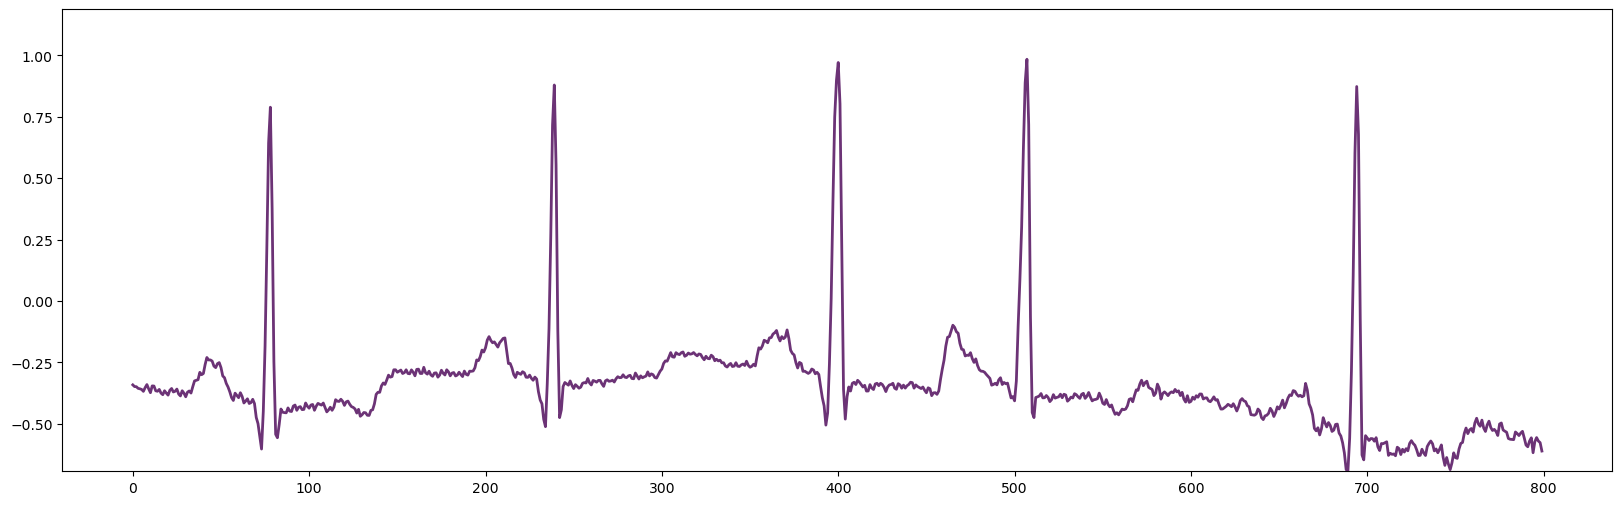


Klasteriai su 'S' anotacija:

ML anotacija S :
item:      0   cluster:      0   statistika: ['S'] [6] 6

item: 0 cluster: 0 size: 6
statistika klasteryje:  ['S'] [6] 6


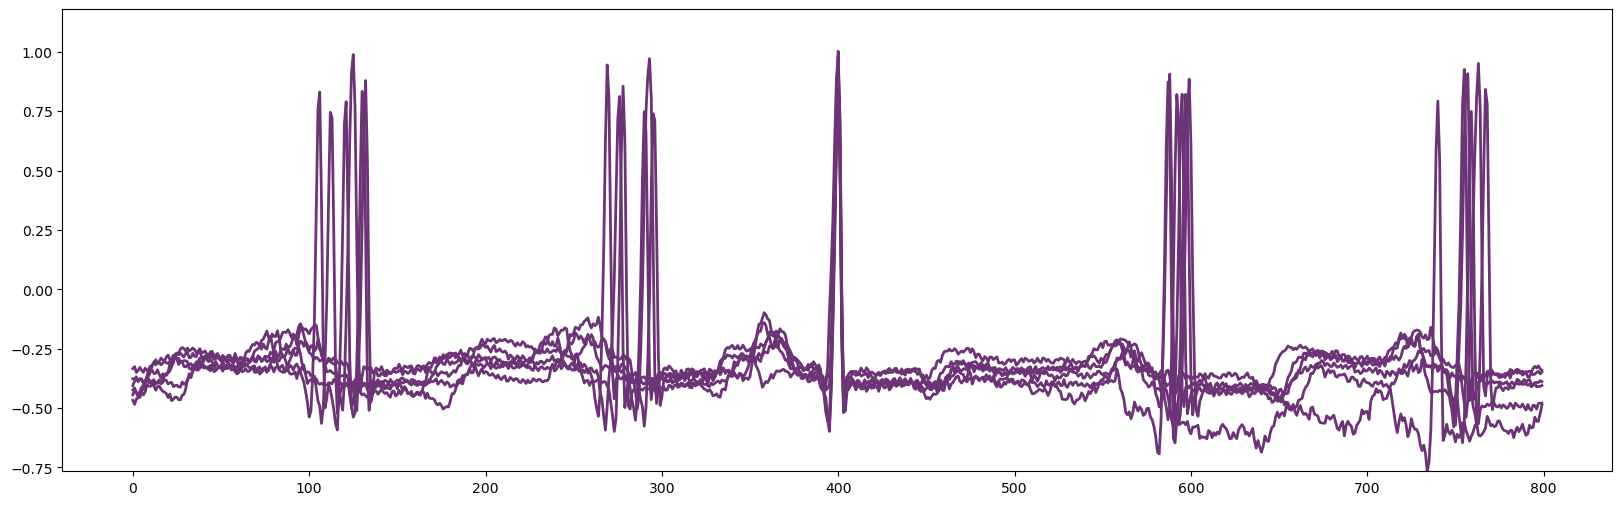

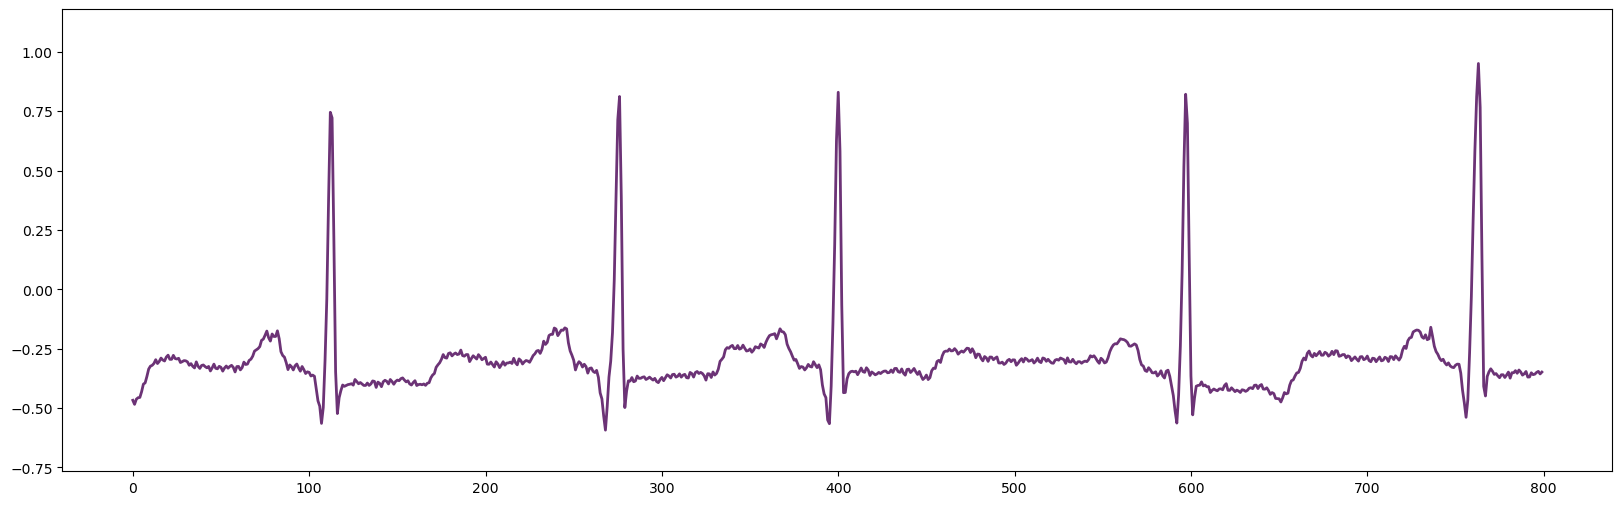


list_dict_clusters_full įrašytas į: 10001.001_rpeaks.json


In [4]:
# Pagrindinis skriptas

print("Skriptas zive-arrh EKG segmentų klasterizacijai")
print('Modelis CNN VU su EKG sekos reikšmėmis, EKG formos požymiais, RR intervalais prieš ir po R dantelio')

my_os=sys.platform
print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'

# Pasiruošimas

# //////////////// NURODOMI PARAMETRAI /////////////////////////////////////////////////////

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'D:\\DI'   # variantas: Windows
    # Duomenu_aplankas = 'F:\DI\Data\MIT&ZIVE\VU'   # variantas: Herkulis
else:
    Duomenu_aplankas = '/home/kesju/DI'   # arba variantas: UBUNTU, be Docker
    # Duomenu_aplankas = '/home/kesju/DI/GITLAB'   # arba variantas: UBUNTU, be Docker

# jei variantas Docker pasirenkame:
# Duomenu_aplankas = '/Data/MIT&ZIVE'

# Naudojamų požymių sąrašas 

all_features = ['seq_size','RR_l_0', 'RR_r_0', 'RR_r/RR_l', 'wl_side','wr_side',
                'signal_mean', 'signal_std', 'P_val', 'Q_val', 'R_val', 'S_val', 'T_val',
                'P_pos', 'Q_pos', 'R_pos', 'S_pos', 'T_pos', 'QRS', 'PR', 'ST', 'QT', '0', '1', '2',
                '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
                '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
                '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
                '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74',
                '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
                '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
                '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114',
                '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126',
                '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138',
                '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150',
                '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162',
                '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174',
                '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186',
                '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198',
                '199'] # 222 požymiai


# Vietinės talpyklos aplankas ir pūpsnių atributų failas
db_folder = 'DUOM_2022_RUDUO_2'
# db_folder = 'analysis'

# Failai pūpsnių klasių formavimui
selected_beats = {'N':0, 'S':1, 'V':2}
all_beats =  {'N':0, 'S':1, 'V':2, 'U':3}  


# Diskretizavimo dažnis:
fs = 200

# /////////////////////////////////////////////////////////////////

#  Nuoroda į aplanką su MIT2ZIVE duomenų rinkiniu
db_path = Path(Duomenu_aplankas, db_folder)

# Nuoroda į aplanką su EKG įrašais (.npy) ir anotacijomis (.json)
rec_dir = Path(db_path, 'records_selected')
# rec_dir = Path(db_path, 'test')

# Nuoroda į modelio aplanką
model_dir = Path(Duomenu_aplankas, 'MODELIAI', 'model_cnn_fda_vu_v1')
# model_dir = 'model_cnn_fda_vu_v1'

# Užduodame, ar filtruojame įrašus
Filtr_flag = False  # True - filtruoti


# Išvedame parametrus
print("\nBendras duomenų aplankas: ", Duomenu_aplankas)
print("Zive duomenų aplankas: ", db_folder)
print("Aplankas su originaliais EKG įrašais ir anotacijomis (.json) ", rec_dir)
print("Diskretizavimo dažnis: ", fs)
print('Klasifikavimo schema:', selected_beats)
print('Klasių skaičius:', len(selected_beats))
print('Visos galimos anotacijos:', list(all_beats.keys()))
print("Modelio ir scaler parametrai nuskaitomas iš aplanko: ", model_dir)
# print("\n")

if (Filtr_flag):
    # Filtruojame izoliniją su 0.5 Hz žemo dažnumo filtru
    lowcut = 0.5
    method = 'butterworth'
    order = 5
    print(f"\nEKG įrašai filtruojami su Neurokit2")
    print(f"Parametrai: lowcut:{lowcut} method: {method} order: {order} ")
else:
    print(f"\nEKG įrašas nefiltruotas")
print()

# PASIRUOŠIMAS

# pd.set_option("display.max_rows", 6000)
# pd.set_option("display.max_columns",200)
# pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore")

print(f"Atliekama pūpsnių su anotacijomis {list(selected_beats.keys())} pacientų įrašuose klasifikacija ir klasterizacija")

# NURODOME PACIENTŲ SĄRAŠĄ
# VARIANTAS, KAI UŽDUODAMI FAILŲ VARDAI IR SKAITOMI ORIGINALUS ZIVE FAILAI 
# 20 atrinktų testinių sąrašas
FileNames = [
1626934.963,
1626931.201,
1630715.664,
1630714.569,
1630729.576,
1630735.143,
1630693.635,
1630734.526,
1630718.396,
1630721.49,
1631139.883,
1631083.411,
1631039.923,
1631029.786,
1632342.032,
1633428.56,
1633584.898,
1633405.853,
1634112.089,
1636451.86
]

FileNames = [1626934.963] #

# 4 testiniai įrašai GitLab
FileNames = [1625400.796, 1625402.027, 1630757.924, 1631141.764] #  

FileNames = [1625400.796] #
FileNames = [1625402.027] #

FileNames = [1631141.764] # visi sutampa
FileNames = [1630757.924] # nesutampa

# Sąrašas testavimui

# Eil. Nr.	userNr	recNr	N	S	V	U	Nml	Sml	Vml	Uml	filename	recId	                    nesutmp	quality	pastabos
# 70	    1009	0	    719	21	0	0	682	40	16	2	1631141.137	613b22d53d08d4ea5fcdc9ec	1	    0
# 263	    1019	37	    625	0	52	0	629	2	39	7	1631039.807	6145fd97bd0cc57934275be0	1	    0
# 426	    1030	27	    936	31	0	0	912	31	22	2	1633434.198	61632c1f1e32556d01017c33	1	    0
# 713	    1053	0	    537	16	0	0	531	16	0	6	1636495.646	6190db883cd1d229b43041fb	1	    0
# 266	    1019	40	    691	0	51	0	690	0	47	5	1631027.284	6145fd97bd0cc54b03275bba	1	    0


FileNames = [
            1625405.103, # 1,  nesutampančių 10, anotatoriaus panaikintų rpikų: 3, pridėtų: 7
            1642627.410, # 0,  nesutampančių 41, anotatoriaus panaikintų rpikų: 41, pridėtų: 0    
            1638801.784, # 2 ,  nesutampančių 40, anotatoriaus panaikintų rpikų: 22, pridėtų: 18
            1637623.546, # 0 ,  nesutampančių 37, anotatoriaus panaikintų rpikų: 37, pridėtų: 0
            1637622.288, # 1 ,  nesutampančių 33, anotatoriaus panaikintų rpikų: 32, pridėtų: 1
            1636596.765, # 0 ,  nesutampančių 22, anotatoriaus panaikintų rpikų: 21, pridėtų: 1
            1632731.258, # 0 ,  nesutampančių 22, anotatoriaus panaikintų rpikų: 21, pridėtų: 1
            1632729.377] # 0 ,  nesutampančių 19, anotatoriaus panaikintų rpikų: 0, pridėtų: 19


FileNames = [ 1630733.908] # 0, be 'Uml'
# Column1	userNr	recordingNr	recId	                    file_name	N	S	V	U	Nml	Sml	Vml	Uml
# 21	    1005	0	        613f56f73d08d4485dcdcb87	1630733.908	559	5	0	0	562	0	0	2

FileNames = [ 1642627.410] # 0, su 'Uml'
# Column1	userNr	recordingNr	recId	                    file_name	N	S	V	U	Nml	Sml	Vml	Uml
# 982	    1079	2	        61f169b8632a33c19e0c7b61	1642627.41	505	0	37	0	508	25	0	9	


FileNames = [ 1642627.410, 1630733.908]
FileNames = [10001.001]

# mark1

# Klasių simbolinių vardų sąrašas ir klasių skaičius
class_names = list(selected_beats.keys()) 
n_classes = len(selected_beats)
# print(class_names)

# CIKLAS PER PACIENTŲ ĮRAŠUS

file_names=["%.3f" % i for i in FileNames]
print("Įrašų sąrašas:", file_names)

# Ciklas per visą įrašų sąrašą
for file_name in file_names:
    print(f"\nZive įrašas:  {file_name:>2}")

# mark2
 # ////////////////////////////////////////////////////////////////////////////////////////
    # Šita dalis skirta atr_sample ir atr_symbol parengimui
    # Jie bus gauti kombinuojant Neurokit rpeaks ir anotacijas iš json
    # Įrašas prieš ieškant rpeaks su Neurokit gali būti filtruojamas

    # Paruošiame įrašą rpeaks suradimui panaudojant Neurokit

    # Nuskaitome EKG įrašą (Zive formatu)
    filepath = Path(rec_dir, file_name)
    # sign_raw = zive_read_file_1ch(filepath)
    sign_raw = read_signal(rec_dir, file_name)
    signal_length = sign_raw.shape[0]
    signal = sign_raw
    
    # Filtracija/ arba ne
    if (Filtr_flag):
        signal = nk.signal_filter(signal=sign_raw, sampling_rate=200, lowcut=lowcut, method=method, order=order)
        # signal = nk.signal_filter(signal=sign_raw, sampling_rate=200, lowcut=0.2, method="butterworth", order=5)
        signal_length = signal.shape[0]
    else:
        signal = sign_raw
        signal_length = sign_raw.shape[0]

    # Surandame rpeaks su Neurokit
    ecg_signal_df = pd.DataFrame(signal, columns=['orig'])
    analysis_results = AnalyseHeartrate(ecg_signal_df)
    rpeaks = np.array(analysis_results['rpeaks'])
    # print(f"rpeaks iš signal: {len(rpeaks)}")

    # Surandame ir išvedame įrašo atributus
    userId, recId = zive_read_rec_id(rec_dir, file_name)
    print(f"file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}  rpeaks: {len(rpeaks)}")

    pred_y, json_object = classify_clusterise_cnn_fda_vu_v1(signal, rpeaks, model_dir, all_features)
   

     # Writing  json_object to file
    fname = file_name + '_rpeaks.json'
    with open(fname, "w") as outfile:
        outfile.write(json_object)
    print("\nlist_dict_clusters_full įrašytas į:", fname)

    # pred_labels turi būti tokio pat ilgio, kaip ir test_labels
    # if (len(test_labels) != len(pred_labels)):
    #     raise Exception(f"Klaida! file_name: {file_name}. Nesutampa test_labels ir pred_labels ilgiai")     
    # print("pred_labels: ", list(all_beats.keys()), label_sums_ml, "Total:", total)

    